## **Imports**

In [ ]:
import os

import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import random

import cv2
import random

from scipy import ndimage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Preprocessing**

In [ ]:
images_dir = '/content/drive/MyDrive/Sonar images/data_set'
train_dir = os.path.join(images_dir, 'train')
test_dir = os.path.join(images_dir, 'test')

In [ ]:
print(images_dir)
print(train_dir)
print(test_dir)

/content/drive/MyDrive/Sonar images/data_set
/content/drive/MyDrive/Sonar images/data_set/train
/content/drive/MyDrive/Sonar images/data_set/test


In [ ]:
train_files = []
test_files = []

for files in os.listdir(train_dir):
  path = os.path.join(train_dir, files)
  train_files.append(path)

for files in os.listdir(test_dir):
  path = os.path.join(test_dir, files)
  test_files.append(path)

print(train_files)
print(test_files)

['/content/drive/MyDrive/Sonar images/data_set/train/object-sideways-frame-048.png', '/content/drive/MyDrive/Sonar images/data_set/train/tire-301.png', '/content/drive/MyDrive/Sonar images/data_set/train/propeller-70.png', '/content/drive/MyDrive/Sonar images/data_set/train/ship199.png', '/content/drive/MyDrive/Sonar images/data_set/train/can-363.png', '/content/drive/MyDrive/Sonar images/data_set/train/hook-70.png', '/content/drive/MyDrive/Sonar images/data_set/train/hook-101.png', '/content/drive/MyDrive/Sonar images/data_set/train/valve-186.png', '/content/drive/MyDrive/Sonar images/data_set/train/can-37.png', '/content/drive/MyDrive/Sonar images/data_set/train/ship-021-1.png', '/content/drive/MyDrive/Sonar images/data_set/train/tire-243.png', '/content/drive/MyDrive/Sonar images/data_set/train/ship-322.png', '/content/drive/MyDrive/Sonar images/data_set/train/bottle-40.png', '/content/drive/MyDrive/Sonar images/data_set/train/ship-356.png', '/content/drive/MyDrive/Sonar images/data

In [ ]:
len(train_files)

3015

In [ ]:
def rotate_img(img, rot):
    if rot == 0:  # 0 degrees rotation
        return img
    elif rot == 90:  # 90 degrees rotation
        return np.flipud(np.transpose(img, (1, 0, 2)))
    elif rot == 180:  # 90 degrees rotation
        return np.fliplr(np.flipud(img))
    elif rot == 270:  # 270 degrees rotation / or -90
        return np.transpose(np.flipud(img), (1, 0, 2))
    elif rot == 120:
        return ndimage.rotate(img, 120, reshape=False)
    elif rot == 240:
        return ndimage.rotate(img, 240, reshape=False)
    else:
        raise ValueError('rotation should be 0, 90, 120, 180, 240 or 270 degrees')

In [ ]:
idx = random.randint(0, len(train_files))
sample = train_files[idx]
img_0 = cv2.imread(sample)
img_0 = cv2.resize(img_0,(224,224))

if(len(img_0.shape)==2):
  img_0 = np.stack((img_0,)*3, axis=-1)
  
img_1 = rotate_img(img_0,90)
img_2 = rotate_img(img_0,120)
img_3 = rotate_img(img_0,180)
img_4 = rotate_img(img_0,240)
img_5 = rotate_img(img_0,270)
img = [img_0,img_1,img_2,img_3,img_4,img_5]
img = np.array(img)
class_labels = ['0 - 0','90 - 1','120 - 2','180 - 3','240 - 4 ','270 - 5']

In [ ]:
img[0].shape

(224, 224, 3)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

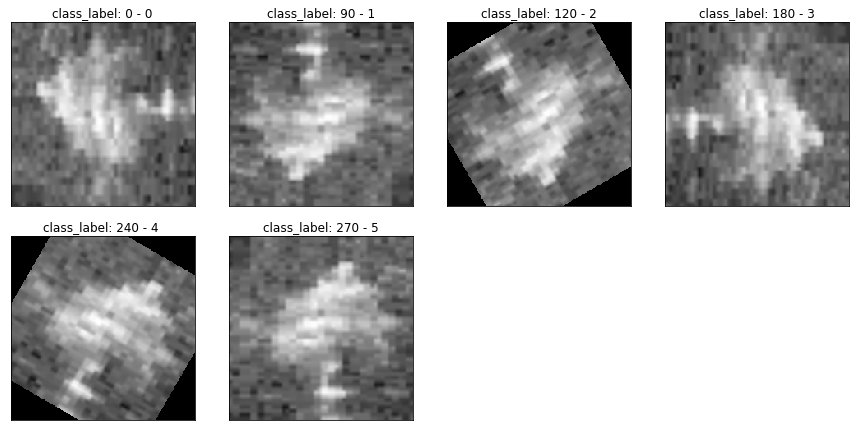

In [ ]:
#### we can plot the data and see by ourselves
fig = plt.figure(1,figsize=(12,12))
for i in range(6):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  #x[i] = x[i][:,:,::-1] # converting BGR to RGB
  plt.imshow(img[i][:,:,::-1], interpolation='none')
  plt.title("class_label: {}".format(class_labels[i]))
  plt.xticks([])
  plt.yticks([])
plt

## **Utils**

In [ ]:
from glob import glob
from skimage import io
import numpy as np
from tqdm import tqdm

images = glob(train_dir)

# since pytorch ToTransform() converts teh image to range of [0,1], we can compute the 
# mean in raneg of that
for i, im_name in tqdm(enumerate(train_files)):
    
    image = io.imread(im_name)
    #if you want your std and mean in range of [0,1]
    image=image/255
    if i == 0:
        mean = np.mean(image, axis=(0,1), keepdims=True)
        std_dev = np.std(image, axis=(0,1), keepdims=True)

        print(mean.shape)
        print(mean)
        print(std_dev)
        break
    else:
        mean = np.append(mean, np.mean(image, axis=(0,1), keepdims=True), axis=0)
        std_dev = np.append(std_dev, np.std(image, axis=(0,1), keepdims=True), axis=0)

print(np.mean(mean, axis=(0,1)))
print(np.mean(std_dev, axis=(0,1)))

0it [00:01, ?it/s]

(1, 1, 3)
[[[0.52318417 0.52318417 0.52318417]]]
[[[0.17053859 0.17053859 0.17053859]]]
[0.52318417 0.52318417 0.52318417]
[0.17053859 0.17053859 0.17053859]


In [ ]:
import yaml
import os
import torch
import shutil
import logging
import matplotlib.pyplot as plt
import numpy as np

class dotdict(dict):
    """dot.notation access to dictionary attributes
    This function is taken from stackoverflow answer by farrell
    and derek- https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
    """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def load_yaml(config_file,config_type='dict'):
    with open(config_file) as f:
        cfg = yaml.safe_load(f)
        #params = yaml.load(f,Loader=yaml.FullLoader)
        
    if config_type=='object':
        cfg = dotdict(cfg)
    return cfg
    
def save_yaml(config,save_path='config.yaml'):
    if type(config)!=dict:
        config=dict(config)
    with open(save_path, 'w') as file:
        yaml.dump(config, file)
        
def save_checkpoint(state, is_best, save_path, checkpoint='checkpoint.pth', best_model='model_best.pth'):
    """ Save model. """
    os.makedirs(save_path, exist_ok=True)
    torch.save(state, save_path + '/' + checkpoint)
    if is_best:
        shutil.copyfile(save_path + '/' + checkpoint, save_path + '/' + best_model)

def load_checkpoint(checkpoint, model, device='cuda',optimizer=None):
    """Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        model: (torch.nn.Module) model for which the parameters are loaded
        optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """

    if not os.path.exists(checkpoint):
        raise("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint,map_location=device)
    try:
        model.load_state_dict(checkpoint['state_dict'],strict=False)
    except:
        model.load_state_dict(checkpoint,strict=False)

#    state = torch.load(path, map_location='cuda:0')
    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

#    return checkpoint
        
def set_logger(log_path):
    """Set the logger to log info in terminal and file `log_path`.
    In general, it is useful to have a logger so that every output to the terminal is saved
    in a permanent file. Here we save it to `model_dir/train.log`.
    Example:
    ```
    logging.info("Starting training...")
    ```
    Args:
        log_path: (string) where to log
    """
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if not logger.handlers:
        # Logging to a file
        file_handler = logging.FileHandler(log_path)
        file_handler.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s: %(message)s'))
        logger.addHandler(file_handler)
        
        # Logging to console
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(logging.Formatter('%(message)s'))
        logger.addHandler(stream_handler)
        
def visualize(input_arr,labels):
    
    fig = plt.figure(figsize=(12,12))
    if len(input_arr.shape)==4:
        num_imgs=input_arr.shape[0]
    else:
        num_imgs=1
        input_arr=np.expand_dims(input_arr,axis=0)
        labels=[labels]
    rows=np.sqrt(num_imgs)
    rows=int(np.ceil(rows))
    for i in range(num_imgs):
      plt.subplot(rows,rows,i+1)
      plt.tight_layout()
      img = input_arr[i]
      img = np.rollaxis(img,0,3)
      plt.imshow(img, interpolation='none')
      plt.title("class_label: {}".format(labels[i]))
      plt.xticks([])
      plt.yticks([])

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def rotate_img_helper(img, rot):
    if rot == 0:  # 0 degrees rotation
        return img
    elif rot == 90:  # 90 degrees rotation
#        return np.flipud(np.transpose(img, (1, 0, 2)))
        return img.rotate(90)
    elif rot == 180:  # 90 degrees rotation
#        return np.fliplr(np.flipud(img))
        return img.rotate(180)
    elif rot == 270:  # 270 degrees rotation / or -90
#        return np.transpose(np.flipud(img), (1, 0, 2))
        return img.rotate(270)
    elif rot == 120:
#        return ndimage.rotate(img, 120, reshape=False)
        return img.rotate(120)
    elif rot == 240:
#        return ndimage.rotate(img, 240, reshape=False)
        return img.rotate(240)
    else:
        raise ValueError('rotation should be 0, 90, 120, 180, 240 or 270 degrees')

In [ ]:
class RunningAverage():
    """A simple class that maintains the running average of a quantity
    
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """
    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
    
    def __call__(self):
        return self.total/float(self.steps)
    
def compute_acc(output,target,topk=(1,)):
    
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k)
    return res

## **Data Loader**

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 
import pandas as pd
from itertools import islice
import cv2

#%%
class SonarDataset(Dataset):
    """ Sonar Dataset Class loader """
    
    def __init__(self, data_path, pretext = 'rotation',  num_rot = 4, data_type = 'train', \
                 transform = None):
        
        """
        Args:
            data_oath (string):  directory with images
            pretext (string): 
            num_rot (int):
            data_type (string):
            transform (torch.transforms): 
        """
        
        self.data_path = data_path
        # self.label_path = os.path.join(cfg.root_path,cfg.data_path,cfg.labels_dir,annotation_file)
        self.transform = transform
        self.pretext = pretext
        if self.pretext == 'rotation':
            self.num_rot = num_rot
        self._load_data()

    def _load_data(self):
        '''
        function to load the data in the format of [[img_name_1,label_1],
        [img_name_2,label_2],.....[img_name_n,label_n]]
        '''
        # self.labels = pd.read_csv(self.label_path)
        
        self.loaded_data = []

        img_files = os.listdir(self.data_path)

        for fi in img_files:
  
            img_name = os.path.join(self.data_path, fi)

            img = Image.open(img_name)
            
            np_img = np.array(img)
            if(len(np_img.shape)==2):
              np_img = np.stack((np_img,)*3, axis=-1)
            if len(np_img.shape) > 2 and np_img.shape[2] == 4:
              #convert the image from RGBA2RGB
              np_img = np_img[:,:,:3]
            
            img = Image.fromarray(np_img.astype('uint8'))

            self.loaded_data.append((img, img_name))
            img.load()  #This closes the image object or else you will get too many open file error

    def __len__(self):
        return len(self.loaded_data)

    def __getitem__(self, idx):

        idx = idx % len(self.loaded_data)
        img, img_name = self.loaded_data[idx]  
        img, label = self._read_data(img)
        
        return img,label,idx,img_name

    def _read_data(self, img, label=None):
        '''
        function to read the data
        '''
        # print(img)
        if self.pretext == 'rotation':
        # if in rotnet mode define a loader function that given the
        # index of an image it returns the 4 rotated copies of the image
        # plus the label of the rotation, i.e., 0 for 0 degrees rotation,
        # 1 for 90 degrees, 2 for 180 degrees, and 3 for 270 degrees.
            if self.num_rot == 4:
                rotated_imgs = [
                    self.transform(img),
                    self.transform(rotate_img_helper(img, 90).copy()),
                    self.transform(rotate_img_helper(img, 180).copy()),
                    self.transform(rotate_img_helper(img, 270).copy())
                ]
                rotation_labels = torch.LongTensor([0, 1, 2, 3])
                
            elif self.num_rot == 3:
                rotated_imgs = [
                    self.transform(img),
                    self.transform(rotate_img_helper(img, 120).copy()),
                    self.transform(rotate_img_helper(img, 240).copy())
                ]
                rotation_labels = torch.LongTensor([0,1,2])
        
            return torch.stack(rotated_imgs, dim=0), rotation_labels
                        
        else:
            # supervised mode; if in supervised mode define a loader function 
            #that given theindex of an image it returns the image and its 
            #categorical label
            img = self.transform(img)
            return img, label
        
def rotnet_collate_fn(batch):
    
    batch = default_collate(batch)
    #assert(len(batch) == 2)
    # 10x4x3x128x128
    # 40 x3x128x128
    batch_size, rotations, channels, height, width = batch[0].size() 
    batch[0] = batch[0].view([batch_size * rotations, channels, height, width])
    batch[1] = batch[1].view([batch_size * rotations])
    return batch

In [ ]:
transform_ssl = transforms.Compose([transforms.Resize((128,128)),
                                        transforms.ToTensor()]) 

dataset = SonarDataset(train_dir, transform = transform_ssl)

3015


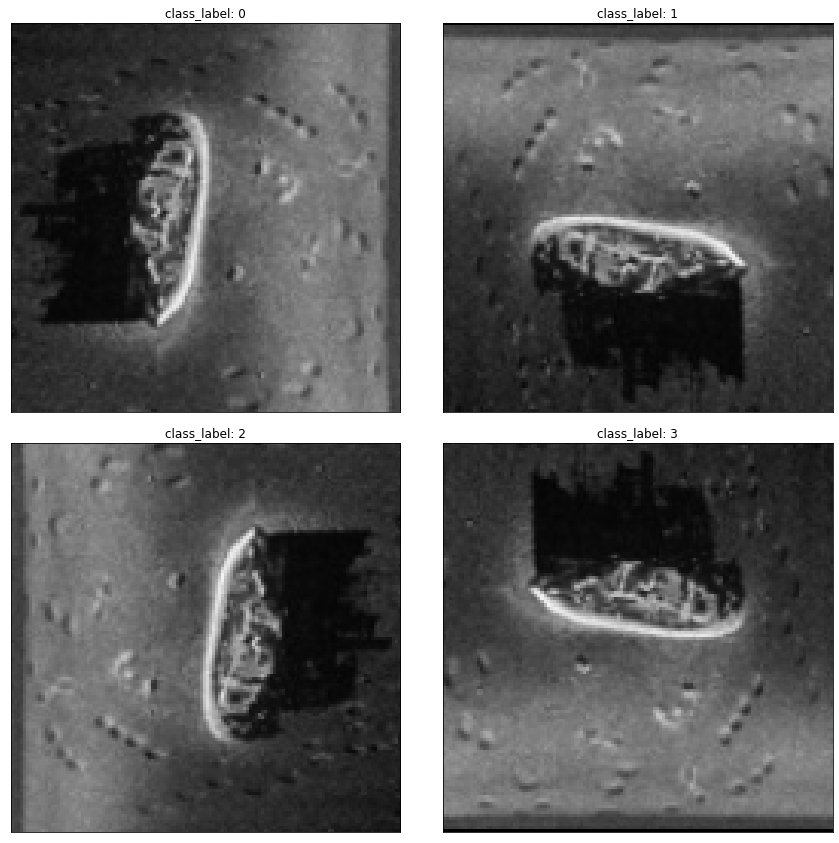

In [ ]:
print(len(dataset))
img,label,idx,img_name = dataset[3]

if type(img)==torch.Tensor:
    visualize(img.numpy(),label)
else:
    visualize(img,label)

In [ ]:
data_loader = DataLoader(dataset,batch_size=4,collate_fn=rotnet_collate_fn,shuffle=True)

torch.Size([16, 3, 128, 128]) tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
torch.Size([16, 3, 128, 128]) tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
torch.Size([16, 3, 128, 128]) tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
torch.Size([16, 3, 128, 128]) tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])


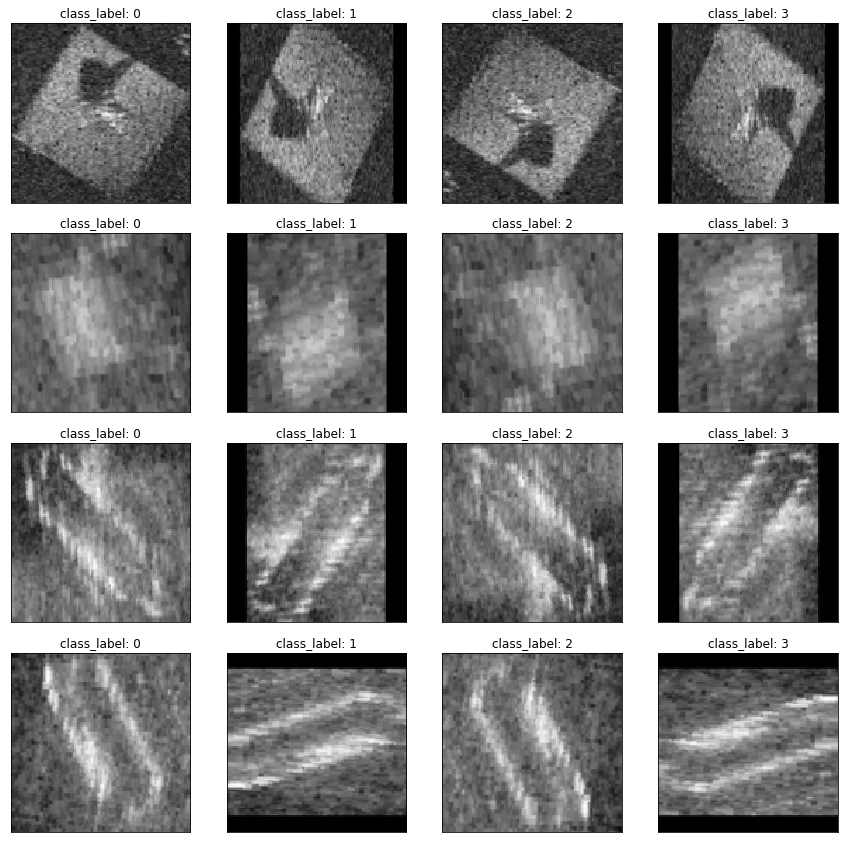

In [ ]:
for data,label,idx,img_names in islice(data_loader,4):
    print(data.shape, label)

visualize(data.numpy(),label.numpy())   

## **Training**

In [ ]:
import os,sys
import numpy as np
from tqdm import tqdm
from itertools import islice
import yaml

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import DataLoader 
from torch.utils.data.dataloader import default_collate
from torch.utils.tensorboard import SummaryWriter


from PIL import Image
import matplotlib.pyplot as plt

#from lshash.lshash import LSHash
import logging

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
transform_ssl = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 

train_dataset = SonarDataset(train_dir, transform = transform_ssl)
test_dataset = SonarDataset(test_dir, transform = transform_ssl)

In [ ]:
train_dataloader =  DataLoader(train_dataset,batch_size=4,collate_fn=rotnet_collate_fn,shuffle=True)
test_dataloader =  DataLoader(test_dataset,batch_size=4,collate_fn=rotnet_collate_fn,shuffle=True)

torch.Size([16, 3, 128, 128]) tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
torch.Size([16, 3, 128, 128]) tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
torch.Size([16, 3, 128, 128]) tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
torch.Size([16, 3, 128, 128]) tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])


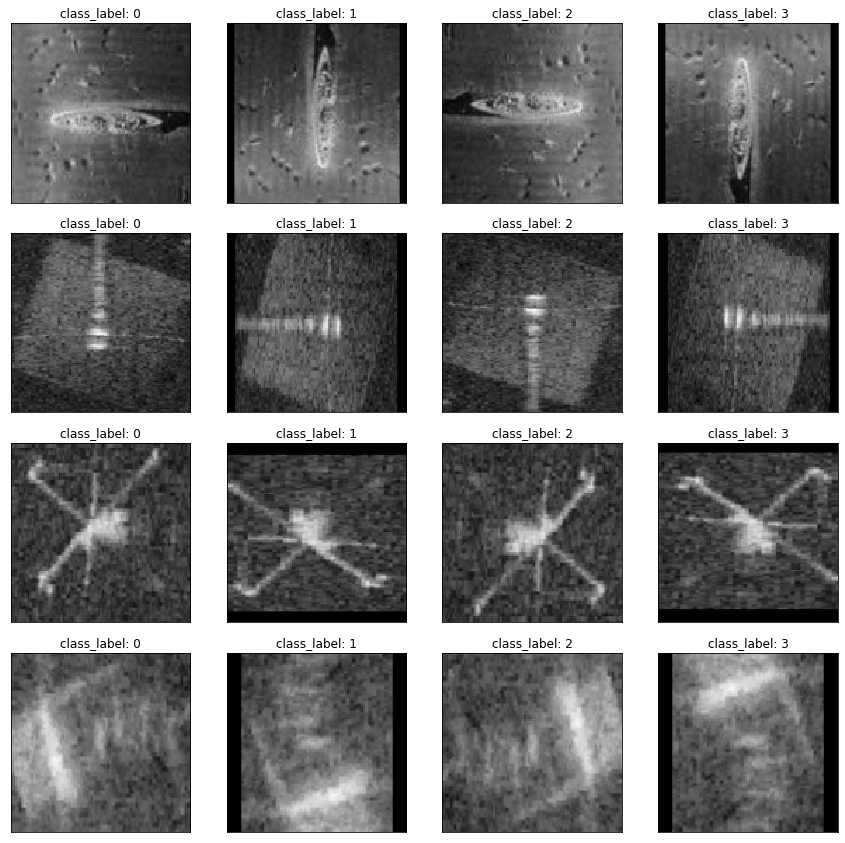

In [ ]:
for data,label,idx,img_names in islice(data_loader,4):
    print(data.shape, label)

visualize(data.numpy(),label.numpy())   

In [ ]:
import torchvision.models as models
import torch.nn as nn

def get_model(network, numrotations=4, pretext='rotation',pretrained=False):
    if network=='resnet18':
        model = models.resnet18(pretrained=pretrained)
        if pretext=='rotation':
            num_classes=numrotations
        model.fc = nn.Linear(in_features=model.fc.in_features,out_features=num_classes,bias=True)
        return model
    if network=='vgg19':
        model = models.vgg19(pretrained=pretrained)
        if pretext=='rotation':
            num_classes=numrotations
        model.classifier[6] = nn.Linear(4096,num_classes)
        return model

def load_checkpoint(model,checkpoint_path,device):
    pass

class LogisticRegression(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogisticRegression, self).__init__()

        self.model = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
from torchvision.models.resnet import resnet18

model = get_model('vgg19', pretrained=True)
model = model.to(device)

In [ ]:
lr=1e-5
scheduler=True
optimizer = optim.Adam(model.parameters(), lr=float(lr))#, momentum=float(cfg.momentum), weight_decay=5e-4, nesterov=True)

if scheduler:
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160, 200], gamma=0.2)
else:
    scheduler=None
criterion = nn.CrossEntropyLoss()

In [ ]:
no_of_epochs = 30
save_intermediate_weights = 2
save_path = os.path.join(images_dir, 'checkpoints')
os.makedirs(save_path, exist_ok=True)

for epoch in range(no_of_epochs):
  # progbar = tqdm(total=len(train_dataloader), desc='Train')
  loss_record = RunningAverage()
  acc_record = RunningAverage()
  correct=0
  total=0

  model.train()
  for batch_idx, (data, label, _,_) in enumerate(tqdm(train_dataloader)):
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)

      # measure accuracy and record loss
      confidence, predicted = output.max(1)
      correct += predicted.eq(label).sum().item()
      #acc = utils.compute_acc(output, label)
      total+=label.size(0)
      acc = correct/total
      
      acc_record.update(100*acc)
      loss_record.update(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
  if scheduler:  
      scheduler.step()
  LR=optimizer.param_groups[0]['lr']
  print('Train Epoch: {} LR: {:.5f} Avg Loss: {:.4f}; Avg Acc: {:.4f}'.format(epoch,LR, loss_record(), acc_record()))


  loss_record_val = RunningAverage()
  acc_record_val = RunningAverage()
  correct=0
  total=0

  model.eval()
  for batch_idx, (data, label, _,_) in enumerate(tqdm(test_dataloader)):
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)

      # measure accuracy and record loss
      confidence, predicted = output.max(1)
      correct += predicted.eq(label).sum().item()
      #acc = utils.compute_acc(output, label)
      total+=label.size(0)
      acc = correct/total
      
      acc_record_val.update(100*acc)
      loss_record_val.update(loss.item())
        
  print('Validation Epoch: {} LR: {:.5f} Avg Loss: {:.4f}; Avg Acc: {:.4f}'.format(epoch,LR, loss_record_val(), acc_record_val()))
  
  if epoch % save_intermediate_weights==0:
    save_checkpoint({'Epoch': epoch,'state_dict': model.state_dict(),
                            'optim_dict' : optimizer.state_dict()},
                            is_best=False,
                            save_path = save_path,
                            checkpoint=f'VGG19_normalized{epoch}')

100%|██████████| 754/754 [04:17<00:00,  2.93it/s]


Train Epoch: 0 LR: 0.00001 Avg Loss: 0.3884; Avg Acc: 67.6370


100%|██████████| 151/151 [00:19<00:00,  7.70it/s]


Validation Epoch: 0 LR: 0.00001 Avg Loss: 0.1442; Avg Acc: 92.7574


100%|██████████| 754/754 [04:17<00:00,  2.93it/s]


Train Epoch: 1 LR: 0.00001 Avg Loss: 0.1368; Avg Acc: 93.8915


100%|██████████| 151/151 [00:19<00:00,  7.74it/s]


Validation Epoch: 1 LR: 0.00001 Avg Loss: 0.1055; Avg Acc: 96.4150


100%|██████████| 754/754 [04:18<00:00,  2.91it/s]


Train Epoch: 2 LR: 0.00001 Avg Loss: 0.0920; Avg Acc: 96.5241


100%|██████████| 151/151 [00:19<00:00,  7.77it/s]


Validation Epoch: 2 LR: 0.00001 Avg Loss: 0.1090; Avg Acc: 96.3358


100%|██████████| 754/754 [04:17<00:00,  2.93it/s]


Train Epoch: 3 LR: 0.00001 Avg Loss: 0.0569; Avg Acc: 97.8726


100%|██████████| 151/151 [00:19<00:00,  7.79it/s]


Validation Epoch: 3 LR: 0.00001 Avg Loss: 0.1268; Avg Acc: 95.4469


100%|██████████| 754/754 [04:20<00:00,  2.90it/s]


Train Epoch: 4 LR: 0.00001 Avg Loss: 0.0354; Avg Acc: 99.0680


100%|██████████| 151/151 [00:19<00:00,  7.82it/s]


Validation Epoch: 4 LR: 0.00001 Avg Loss: 0.2054; Avg Acc: 93.5875


100%|██████████| 754/754 [04:20<00:00,  2.90it/s]


Train Epoch: 5 LR: 0.00001 Avg Loss: 0.0256; Avg Acc: 98.8677


100%|██████████| 151/151 [00:19<00:00,  7.82it/s]


Validation Epoch: 5 LR: 0.00001 Avg Loss: 0.1774; Avg Acc: 94.8886


100%|██████████| 754/754 [04:20<00:00,  2.90it/s]


Train Epoch: 6 LR: 0.00001 Avg Loss: 0.0224; Avg Acc: 99.0675


100%|██████████| 151/151 [00:19<00:00,  7.80it/s]


Validation Epoch: 6 LR: 0.00001 Avg Loss: 0.1642; Avg Acc: 95.6259


 79%|███████▊  | 592/754 [03:24<00:55,  2.89it/s]